In [2]:
import os
import sys
import numpy as np

In [3]:
from skimage import data, io, filters
import matplotlib.pyplot as plt

In [4]:
# dimensions of result image
W = 1200
H = 900
CHANNEL_NUM = 3  # we work with rgb images
MAX_VALUE = 255  # max pixel value, required by ppm header
MATHEMATICAL_ERROR = 0.006 #maximum error between the boundaries of the tiles
NUMBER_SIDE_TILES = 4

In [5]:
def read_image(path):
    # second line of header contains image dimensions
    w, h = np.loadtxt(path, skiprows=1, max_rows=1, dtype=np.int32)
    # skip 3 lines reserved for header and read image
    image = np.loadtxt(path, skiprows=3, dtype=np.uint8).reshape((h, w, CHANNEL_NUM))
    return image

In [6]:
def write_image(path, img):
    h, w = img.shape[:2]
    # ppm format requires header in special format
    header = f'P3\n{w} {h}\n{MAX_VALUE}\n'
    with open(path, 'w') as f:
        f.write(header)
        for r, g, b in img.reshape((-1, CHANNEL_NUM)):
            f.write(f'{r} {g} {b} ')

In [35]:
def sum_side_pixels_up(tile):
    return float((tile[0,:,:].reshape(-1)).sum())

In [36]:
def sum_side_pixels_down(tile, h):
    return float((tile[h-1,:,:].reshape(-1)).sum())

In [37]:
def sum_side_pixels_left(tile):
    return float((tile[:,0,:].reshape(-1)).sum())

In [38]:
def sum_side_pixels_right(tile, w):
    return float((tile[:,w-1,:].reshape(-1)).sum())

In [55]:
def find_neighbors_new(find_tile, tiles, h, w, side_find_tile):
    # если side_find_tile = 0 - верхняя сторона, 1 - нижняя сторона, 2 - левая сторона, 3 - правая сторона 
    # проверить соседа 4 тайла с 10
    if side_find_tile == 0:
        sum_side_find_tile = sum_side_pixels_up(tiles[find_tile])
    elif side_find_tile == 1:
        sum_side_find_tile = sum_side_pixels_down(tiles[find_tile], h)
    elif side_find_tile == 2:
        sum_side_find_tile = sum_side_pixels_left(tiles[find_tile])
    else:
        sum_side_find_tile = sum_side_pixels_right(tiles[find_tile], w)

    neighbors_tile = np.zeros(2)
    neighbors_tile[:] = -1
    min_error = 1
    
    # for i in range(5,6):
    for i in range(len(tiles)):
        if i == find_tile:
            continue;
        #ищем минимальную погрешность между пикселями граней тайлов
        error_up = abs(sum_side_find_tile - sum_side_pixels_up(tiles[i])) / (w * 255 * 3)
        error_down = abs(sum_side_find_tile - sum_side_pixels_down(tiles[i], h)) / (w * 255 * 3)
        error_left = abs(sum_side_find_tile - sum_side_pixels_left(tiles[i])) / (h * 255 * 3)
        error_right = abs(sum_side_find_tile - sum_side_pixels_right(tiles[i], w)) / (h * 255 * 3)
        # print(i, error_up, error_down, error_left, error_right, sep='\n', end='\n next \n')
        if (min_error > error_up):
            min_error = error_up
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 0

        if min_error > error_down :
            min_error = error_down
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 1

        if (min_error > error_left):
            min_error = error_left
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 2

        if (min_error > error_right):
            min_error = error_right
            if (min_error <= MATHEMATICAL_ERROR):
              neighbors_tile[0] = i
              neighbors_tile[1] = 3

    return neighbors_tile

In [12]:
def left_neighborhood_compilation(first_tile_i, neighbors_tile, tiles, right_true_tile):
    # ставим соседа слева 
    temp = np.array(tiles[int(neighbors_tile[0])])
    tiles[int(neighbors_tile[0])] = tiles[right_true_tile]
    tiles[right_true_tile] = temp

    for i in range(right_true_tile, first_tile_i, -1):
        tiles[i] = tiles[i-1]

    tiles[first_tile_i] = temp

    #переворот левого соседа
    if (neighbors_tile[1] == 2):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 2)
    elif (neighbors_tile[1] == 1):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 1)
    elif (neighbors_tile[1] == 0):
        tiles[first_tile_i] = np.rot90(tiles[first_tile_i], 3)

    return tiles

In [13]:
def right_neighborhood_compilation(first_tile_i, neighbors_tile, tiles):
    #ставим соседа справа
    temp = np.array(tiles[int( neighbors_tile[0])])

    #переворот правого соседа
    if (neighbors_tile[1] == 3):
        temp = np.rot90(temp, 2)
    elif (neighbors_tile[1] == 1):
        temp = np.rot90(temp, 3)
    elif (neighbors_tile[1] == 0):
        temp = np.rot90(temp, 1)

    tiles[int( neighbors_tile[0])] = tiles[int( first_tile_i + 1 )]
    tiles[int( first_tile_i + 1 )] = temp
    
    return tiles

In [14]:
def print_image(nodes, tiles, result_img, h , w, i):
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]
 
    output_path = "image_output"+ chr( 65 + i) +".ppm"
    write_image(output_path, result_img)

In [111]:
def solve_puzzle(tiles_folder):
    # create placeholder for result image
    # read all tiles in list
    tiles = [read_image(os.path.join(tiles_folder, t)) for t in sorted(os.listdir(tiles_folder))]
    
    tiles = np.array(tiles)

    result_img = np.zeros((H, W, CHANNEL_NUM), dtype=np.uint8)
    # scan dimensions of all tiles and find minimal height and width
    dims = np.array([t.shape[:2] for t in tiles])
    h, w = np.min(dims, axis=0)

    # compute grid that will cover image
    # spacing between grid rows = min h
    # spacing between grid columns = min w
    x_nodes = np.arange(0, W, w)
    y_nodes = np.arange(0, H, h)
    xx, yy = np.meshgrid(x_nodes, y_nodes)
    nodes = np.vstack((xx.flatten(), yy.flatten())).T

    #Расположение тайлов в правильном порядке
    number_of_tiles_in_a_row = W // w
    number_of_tiles_in_a_column = H // h


    # for j in range(number_of_tiles_in_a_column * number_of_tiles_in_a_row):
    #     neighbors_tile = find_neighbors_new(j, tiles, h, w, 3)
    #     print(neighbors_tile, end='\n\n')  
    # neighbors_tile = find_neighbors_new(8, tiles, h, w, 2)
    # tiles = left_neighborhood_compilation(8, neighbors_tile, tiles, 0 + 2 * number_of_tiles_in_a_row + 1)
    # neighbors_tile = find_neighbors_new(0, tiles, h, w, 2)
    # tiles = left_neighborhood_compilation(0, neighbors_tile, tiles, 2)
    # print(neighbors_tile)
    # neighbors_tile = find_neighbors_new(4, tiles, h, w, 0)
    # print()
    # neighbors_tile = find_neighbors_new(4, tiles, h, w, 1)
    # print()
    # neighbors_tile = find_neighbors_new(4, tiles, h, w, 2)
    # print()
    # neighbors_tile = find_neighbors_new(4, tiles, h, w, 3)
    # print(sum_side_pixels_left(tiles[4]), sum_side_pixels_down(tiles[10], h), abs(sum_side_pixels_left(tiles[4]) - sum_side_pixels_down(tiles[10], h))/sum_side_pixels_left(tiles[4]))
    
    # z = 0
    for j in range(number_of_tiles_in_a_column):
        # сосед слева
        neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
        right_tile_i = 0
        print(j *number_of_tiles_in_a_row, neighbors_tile, end='\n1\n')
        while neighbors_tile[0] != -1 and right_tile_i + j * number_of_tiles_in_a_row < number_of_tiles_in_a_row + j * number_of_tiles_in_a_row - 1:
            right_tile_i += 1
            tiles = left_neighborhood_compilation(j*number_of_tiles_in_a_row , neighbors_tile, tiles, right_tile_i + j * number_of_tiles_in_a_row)
            neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 2)
            print(j *number_of_tiles_in_a_row, neighbors_tile, end='\n2\n')
            # print_image(nodes, tiles, result_img, h , w, z)
            # z += 1
        # сосед справа
        neighbors_tile = find_neighbors_new(j *number_of_tiles_in_a_row, tiles, h, w, 3)
        right_tile_i = 0 if right_tile_i <= 0 else right_tile_i - 1 
        neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)
        print(right_tile_i+j *number_of_tiles_in_a_row, neighbors_tile, end='\n3\n')
        while neighbors_tile[0] != -1 and right_tile_i + j * number_of_tiles_in_a_row < number_of_tiles_in_a_row + j * number_of_tiles_in_a_row - 1: 
            tiles = right_neighborhood_compilation(right_tile_i+j*number_of_tiles_in_a_row , neighbors_tile, tiles)
            right_tile_i += 1
            neighbors_tile = find_neighbors_new(right_tile_i + j * number_of_tiles_in_a_row, tiles, h, w, 3)
            print(right_tile_i+j *number_of_tiles_in_a_row, neighbors_tile, end='\n4\n')


    # for j in range(number_of_tiles_in_a_column):
    #   for i in range(number_of_tiles_in_a_row):
    #       neighbors_tile = find_neighbors_new(i+j*number_of_tiles_in_a_row, tiles, h, w, 2)
    #       print(neighbors_tile, end='\n\n')
    # #       tiles = neighborhood_compilation(i+j*number_of_tiles_in_a_row , neighbors_tile, tiles, number_of_tiles_in_a_row)
    # fill grid with tiles
    for (x, y), tile in zip(nodes, tiles):
        result_img[y: y + h, x: x + w] = tile[:h, :w]
 
    output_path = "image_output.ppm"
    write_image(output_path, result_img)

In [115]:
if __name__ == "__main__":
    #directory = sys.argv[1]
    directory = "drive/MyDrive/3Divi/data/0000_0001_0000/tiles"
    solve_puzzle(directory)

0 [21.  3.]
1
0 [14.  1.]
2
0 [7. 1.]
2
0 [26.  2.]
2
0 [24.  2.]
2
0 [29.  0.]
2
0 [15.  0.]
2
0 [30.  2.]
2
6 [42.  2.]
3
7 [4. 3.]
4
8 [19.  1.]
1
8 [21.  0.]
2
8 [0. 1.]
2
8 [31.  1.]
2
8 [35.  2.]
2
8 [13.  2.]
2
8 [27.  1.]
2
8 [37.  2.]
2
14 [47.  2.]
3
15 [28.  1.]
4
16 [19.  1.]
1
16 [17.  0.]
2
16 [8. 0.]
2
16 [24.  0.]
2
16 [44.  3.]
2
16 [23.  1.]
2
16 [25.  3.]
2
16 [9. 2.]
2
22 [21.  0.]
3
23 [32.  0.]
4
24 [41.  2.]
1
24 [-1. -1.]
2
24 [11.  0.]
3
25 [10.  0.]
4
26 [24.  0.]
4
27 [34.  2.]
4
28 [40.  2.]
4
29 [8. 2.]
4
30 [21.  0.]
4
31 [25.  0.]
4
32 [21.  2.]
1
32 [11.  1.]
2
32 [9. 0.]
2
32 [17.  1.]
2
32 [29.  2.]
2
32 [30.  2.]
2
32 [31.  2.]
2
32 [25.  0.]
2
38 [39.  2.]
3
39 [21.  3.]
4
40 [1. 1.]
1
40 [36.  3.]
2
40 [35.  3.]
2
40 [34.  3.]
2
40 [33.  3.]
2
40 [32.  3.]
2
40 [25.  0.]
2
40 [26.  0.]
2
46 [47.  2.]
3
47 [16.  1.]
4


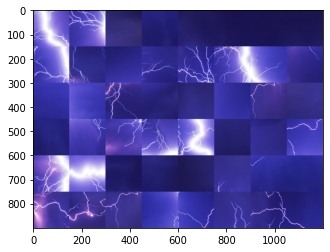

In [116]:
image = read_image("image_output.ppm")
plt.imshow(image)
plt.savefig("image.png")

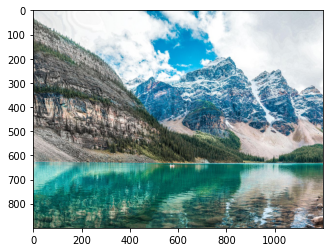

In [18]:
image = read_image("drive/MyDrive/3Divi/data/0000_0000_0000/image.ppm")
plt.imshow(image)
plt.savefig("image_check.png")